# BNN

In [1]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext tensorboard

from bnn_layers import BinaryDense
import utils

print(tf.version.VERSION)

2.10.0


# 定义超参数

In [2]:
# hyper parameters

# train
batch_size = 512
epochs = 10
# learning rate
lr_start = 1e-3
# BN
epsilon = 1e-5
momentum = 0.99
# structure
is_use_bias = True
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_start)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 预处理数据集

Training set images shape:  (48000, 28, 28)
Training set labels shape:  (48000,)
Test set size:  10000
Validation set size:  12000


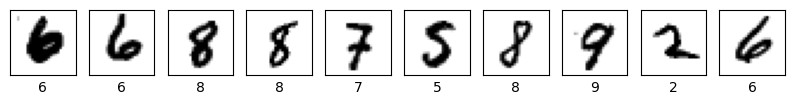

In [3]:
# 导入 MNIST 数据集
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

# 打乱训练集
indices = np.arange(len(train_images))
np.random.shuffle(indices)
train_images = train_images[indices]
train_labels = train_labels[indices]

# 划分20%验证集，并将剩余部分作为新的训练集
num_val_samples = int(len(train_images) * 0.2)
val_images = train_images[:num_val_samples]
val_labels = train_labels[:num_val_samples]
train_images = train_images[num_val_samples:]
train_labels = train_labels[num_val_samples:]

# 输出数据集信息
print("Training set images shape: ", train_images.shape)
print("Training set labels shape: ", train_labels.shape)
print("Test set size: ", test_labels.shape[0])
print("Validation set size: ", val_labels.shape[0])

# 显示前十个图像
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap="binary")
    plt.xlabel(train_labels[i].item())
plt.show()

In [4]:
# 数据预处理
# 将数组中元素的数据类型转换为 float32
train_images = train_images.astype("float32")
test_images = test_images.astype("float32")
val_images = val_images.astype("float32")

# 归一化: 将数据转换到 [0, 1] 的范围内，然后将其馈送到神经网络模型。
train_images, test_images, val_images = (
    train_images / 255.0,
    test_images / 255.0,
    val_images / 255.0,
)

# 模型构建

In [5]:
# Simple MLP for MNIST
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        BinaryDense(
            128,
            use_bias=is_use_bias,
            epsilon=epsilon,
            momentum=momentum,
            is_binarized_activation=False,
        ),
        BinaryDense(64, use_bias=is_use_bias, epsilon=epsilon, momentum=momentum),
        BinaryDense(10, use_bias=is_use_bias, epsilon=epsilon, momentum=momentum),
    ]
)

# 模型编译

In [6]:
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"],
)

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 binary_dense (BinaryDense)  (None, 128)               100992    
                                                                 
 binary_dense_1 (BinaryDense  (None, 64)               8512      
 )                                                               
                                                                 
 binary_dense_2 (BinaryDense  (None, 10)               690       
 )                                                               
                                                                 
Total params: 110,194
Trainable params: 109,790
Non-trainable params: 404
_________________________________________________________________


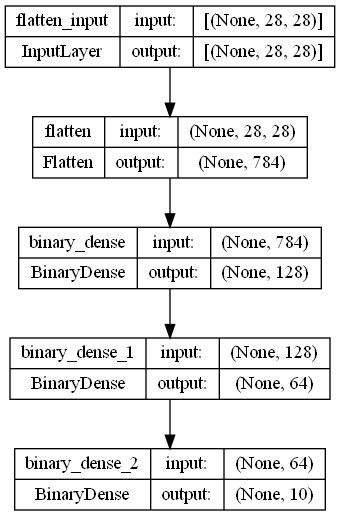

In [7]:
# 创建绘图目录
plts_dir = Path("./plts")
plts_dir.mkdir(parents=True, exist_ok=True)

# 绘制模型结构图(将模型绘制为层计算图)
tf.keras.utils.plot_model(
    model, plts_dir / "BNN_MLP_MNIST_Diagram.png", show_shapes=True
)

# 模型训练

In [8]:
# 配置 TensorBoard 日志回调
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=utils.get_tensorboard_dir(Path("./logs/mlp_mnist/bnn"), is_clear_out=True),
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    profile_batch="10, 15",
)

# 早停 Early Stopping 回调
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

In [9]:
history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_images, val_labels),
    verbose=1,
    # callbacks=[tensorboard_callback, early_stopping_callback],
)

history_dict = history.history

Epoch 1/10
94/94 [==============================] - 4s 15ms/step - loss: 1.0564 - accuracy: 0.7446 - val_loss: 0.6010 - val_accuracy: 0.8418
Epoch 2/10
94/94 [==============================] - 1s 11ms/step - loss: 0.6420 - accuracy: 0.8835 - val_loss: 0.5326 - val_accuracy: 0.8821
Epoch 3/10
94/94 [==============================] - 1s 9ms/step - loss: 0.5209 - accuracy: 0.9071 - val_loss: 0.4911 - val_accuracy: 0.9042
Epoch 4/10
94/94 [==============================] - 1s 10ms/step - loss: 0.4470 - accuracy: 0.9168 - val_loss: 0.4279 - val_accuracy: 0.9126
Epoch 5/10
94/94 [==============================] - 1s 9ms/step - loss: 0.3914 - accuracy: 0.9269 - val_loss: 0.3840 - val_accuracy: 0.9234
Epoch 6/10
94/94 [==============================] - 1s 9ms/step - loss: 0.3475 - accuracy: 0.9331 - val_loss: 0.3540 - val_accuracy: 0.9256
Epoch 7/10
94/94 [==============================] - 1s 10ms/step - loss: 0.3160 - accuracy: 0.9376 - val_loss: 0.3326 - val_accuracy: 0.9309
Epoch 8/10
94/94

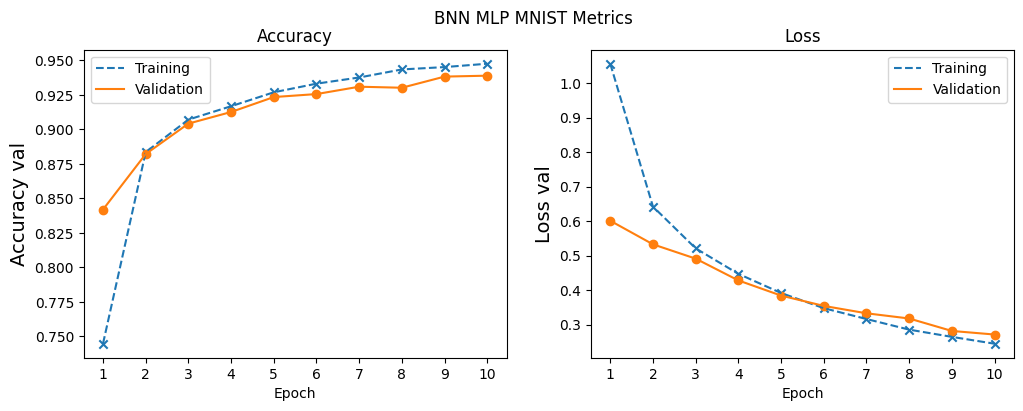

In [10]:
# 绘制训练和验证的损失和准确率图
utils.plt_training_validation_metrics(history_dict, epochs, "BNN MLP MNIST Metrics")
plt.savefig(plts_dir / "BNN_MLP_MNIST_Metrics.png", dpi=600)
plt.show()

# 模型评估

In [11]:
# 评估准确率: 比较模型在测试数据集上的表现
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print("Test loss:", test_loss)
print("Test top-1 accuracy:", test_acc)

313/313 - 1s - loss: 0.2591 - accuracy: 0.9420 - 960ms/epoch - 3ms/step
Test loss: 0.25913524627685547
Test top-1 accuracy: 0.9419999718666077


In [12]:
# 打印训练历史中，最小损失值，以及最大评估指标值
min_history_epoch, min_history = min(
    enumerate(history_dict["loss"], 1), key=lambda x: x[1]
)
print(f"最小训练集损失值loss为    : {min_history:.8f}, 对应的epoch为: {min_history_epoch}")
max_history_epoch, max_history = max(
    enumerate(history_dict["accuracy"], 1), key=lambda x: x[1]
)
print(f"最大训练集准确率acc为     : {max_history:.8f}, 对应的epoch为: {max_history_epoch}")
min_history_epoch, min_history = min(
    enumerate(history_dict["val_loss"], 1), key=lambda x: x[1]
)
print(f"最小验证集损失值val_loss为: {min_history:.8f}, 对应的epoch为: {min_history_epoch}")
max_history_epoch, max_history = max(
    enumerate(history_dict["val_accuracy"], 1), key=lambda x: x[1]
)
print(f"最大验证集准确率val_acc为 : {max_history:.8f}, 对应的epoch为: {max_history_epoch}")

最小训练集损失值loss为    : 0.24437949, 对应的epoch为: 10
最大训练集准确率acc为     : 0.94758332, 对应的epoch为: 10
最小验证集损失值val_loss为: 0.27104041, 对应的epoch为: 10
最大验证集准确率val_acc为 : 0.93891668, 对应的epoch为: 10


In [13]:
# 附加一个 Softmax 层，将logits转换为更容易理解的概率
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
# 使用BNN模型对完整测试集进行预测
predictions = probability_model.predict(test_images)
# 将预测结果转换为类别标签
predicted_labels = np.argmax(predictions, axis=1)

313/313 [==============================] - 1s 3ms/step


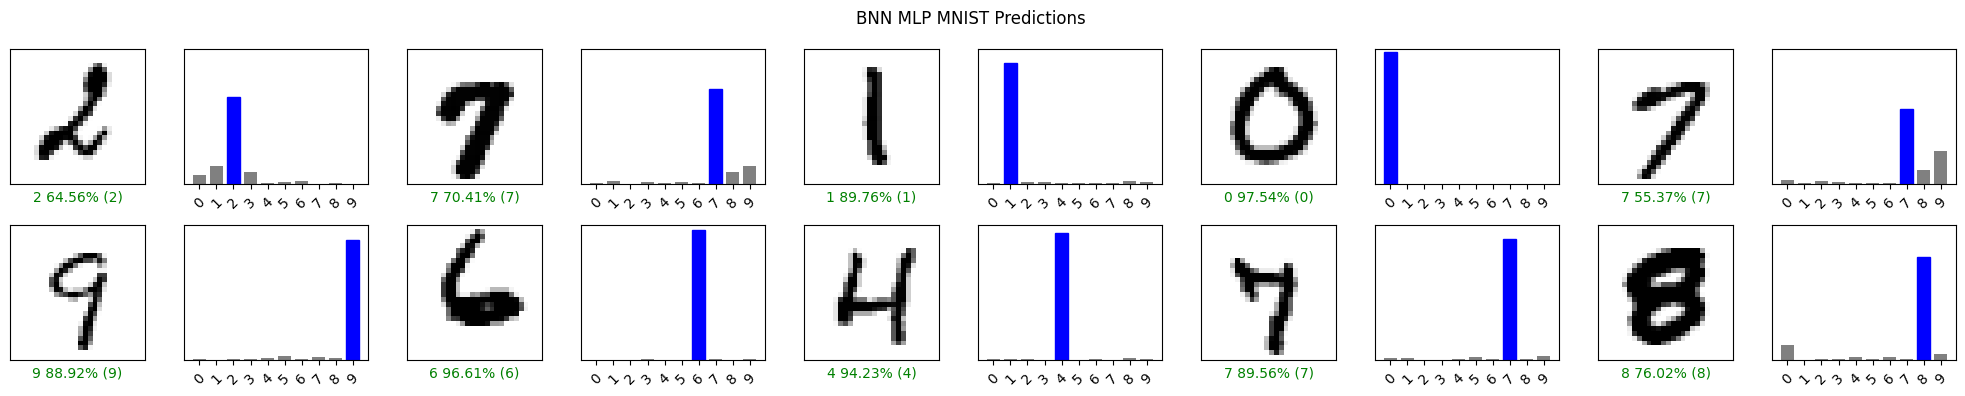

In [14]:
# 从 test_labels 中随机选择 plt_images 个，
plt_rows = 2
plt_cols = 5
plt_images = plt_rows * plt_cols
random_indices_plt = np.random.choice(test_labels.shape[0], plt_images, replace=False)
plt.figure(figsize=(2 * 2 * plt_cols, 2 * plt_rows))
plt.suptitle("BNN MLP MNIST Predictions")
for i in range(plt_images):
    idx_plt = random_indices_plt[i]
    plt.subplot(plt_rows, 2 * plt_cols, 2 * i + 1)
    utils.plt_predict_image(
        idx_plt, predictions, test_labels, class_names, test_images, cmap="binary"
    )
    plt.subplot(plt_rows, 2 * plt_cols, 2 * i + 2)
    utils.plt_predict_value_array(idx_plt, predictions, test_labels, class_names)
plt.tight_layout()
plt.savefig(plts_dir / "BNN_MLP_MNIST_Result", dpi=600)
plt.show()

<Figure size 1000x1000 with 0 Axes>

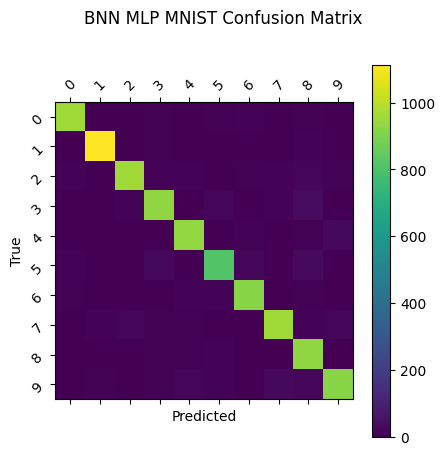

In [15]:
# 绘制混淆矩阵
confusion_mtx = tf.math.confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 10))
plt.matshow(confusion_mtx, cmap="viridis")
plt.suptitle("BNN MLP MNIST Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names, rotation=45)
plt.colorbar()
plt.savefig(plts_dir / "BNN_MLP_MNIST_Confusion", dpi=600)
plt.show()

In [16]:
# TensorBoard 可视化
# %tensorboard --logdir logs/

In [17]:
# 依次打印BNN网络全连接层推理时使用的二值化权重
for i, layer in enumerate(model.layers):
    if isinstance(layer, BinaryDense):
        binarized_weights = layer.get_binarize_weights()
        print(f"Layer {i} Name: {layer.name}, Inference used binarized Weights:")
        print(binarized_weights, "\n")

Layer 1 Name: binary_dense, Inference used binarized Weights:
tf.Tensor(
[[-1  1  1 ... -1 -1  1]
 [-1 -1  1 ...  1 -1 -1]
 [-1  1 -1 ... -1  1  1]
 ...
 [ 1 -1  1 ...  1 -1  1]
 [ 1 -1 -1 ... -1  1  1]
 [ 1  1 -1 ... -1  1  1]], shape=(784, 128), dtype=int8) 

Layer 2 Name: binary_dense_1, Inference used binarized Weights:
tf.Tensor(
[[-1  1 -1 ...  1 -1  1]
 [-1  1 -1 ...  1 -1 -1]
 [-1 -1  1 ...  1 -1  1]
 ...
 [ 1 -1 -1 ... -1  1  1]
 [-1 -1 -1 ...  1  1 -1]
 [ 1 -1 -1 ...  1 -1 -1]], shape=(128, 64), dtype=int8) 

Layer 3 Name: binary_dense_2, Inference used binarized Weights:
tf.Tensor(
[[-1  1  1  1  1 -1 -1 -1 -1  1]
 [ 1 -1 -1  1  1 -1  1  1  1  1]
 [-1 -1  1 -1  1  1 -1  1  1 -1]
 [-1 -1  1 -1  1  1  1 -1  1  1]
 [ 1 -1 -1  1 -1 -1  1  1 -1  1]
 [-1  1 -1 -1  1 -1 -1  1  1  1]
 [-1 -1 -1  1  1  1 -1  1 -1  1]
 [-1 -1 -1 -1 -1  1  1  1 -1  1]
 [ 1 -1  1  1  1 -1  1  1 -1 -1]
 [-1 -1 -1  1 -1  1 -1 -1 -1 -1]
 [-1 -1  1  1  1  1  1 -1  1  1]
 [ 1 -1 -1 -1  1 -1 -1 -1 -1  1]
 [-1